## Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import datetime as dt

## Data Preparation

In [2]:
engine = sqlalchemy.create_engine("sqlite:///data/mta_data.db")
mta_table = engine.table_names()[0]
mta_df = pd.read_sql('SELECT * FROM '+mta_table, engine)
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,00:00:00,REGULAR,7575503,2588978
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,04:00:00,RECOVR AUD,7575515,2588982
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,08:00:00,REGULAR,7575523,2588989
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,12:00:00,REGULAR,7575557,2588996
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,16:00:00,REGULAR,7575630,2589008


### MTA Data
Query data yearly from Jan - May 2021 

In [3]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4602668 entries, 0 to 4602667
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 386.3+ MB


In [4]:
mta_modify_df = mta_df[['C/A','UNIT','SCP','STATION','DATE','ENTRIES']]
mta_df.drop_duplicates(keep='first',inplace=True,ignore_index=True)

In [5]:
mta_modify_df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,05/22/2021,7575503
1,A002,R051,02-00-00,59 ST,05/22/2021,7575515
2,A002,R051,02-00-00,59 ST,05/22/2021,7575523
3,A002,R051,02-00-00,59 ST,05/22/2021,7575557
4,A002,R051,02-00-00,59 ST,05/22/2021,7575630


In [6]:
mta_modify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4602668 entries, 0 to 4602667
Data columns (total 6 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   C/A      object
 1   UNIT     object
 2   SCP      object
 3   STATION  object
 4   DATE     object
 5   ENTRIES  int64 
dtypes: int64(1), object(5)
memory usage: 210.7+ MB


### Population in Each MTA Subway Station 

In [7]:
daily_df = mta_modify_df.groupby(['C/A','UNIT','SCP','STATION','DATE'],as_index=False).ENTRIES.last()

In [8]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2021,7511647
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300


In [9]:
daily_df['PREV_ENTRIES'] = (daily_df.groupby(['C/A','UNIT','SCP','STATION'])[['ENTRIES']].shift(1))

In [10]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2021,7511647,NaN
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,7511647.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,7511996.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,7512214.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,7512754.0


In [11]:
daily_df.dropna(inplace=True)

In [12]:
(daily_df.ENTRIES - daily_df.PREV_ENTRIES).describe()

count    7.633450e+05
mean    -4.450465e+01
std      7.642049e+06
min     -2.139029e+09
25%      5.000000e+01
50%      1.980000e+02
75%      4.180000e+02
max      2.139011e+09
dtype: float64

In [13]:
daily_df['DAILY_ENTRIES'] = (daily_df.ENTRIES - daily_df.PREV_ENTRIES).abs()
daily_df.drop(daily_df[daily_df['DAILY_ENTRIES'] > 1000000].index, inplace=True)

In [14]:
daily_df.describe()

,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
count,7.631250e+05,7.631250e+05,763125.000000
mean,4.196948e+07,4.196948e+07,696.469226
std,2.183445e+08,2.183444e+08,9392.800516
min,0.000000e+00,0.000000e+00,0.000000
25%,2.167720e+05,2.167930e+05,58.000000
50%,1.467998e+06,1.467998e+06,206.000000
75%,6.138391e+06,6.138385e+06,431.000000
max,2.147432e+09,2.147432e+09,984026.000000


In [15]:
daily_df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,7511647.0,349.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,7511996.0,218.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,7512214.0,540.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,7512754.0,546.0
5,A002,R051,02-00-00,59 ST,01/06/2021,7513790,7513300.0,490.0


In [16]:
station_total= daily_df.groupby(['C/A','UNIT','STATION','DATE'])[['DAILY_ENTRIES']].sum().reset_index()
station_total = station_total.groupby(['STATION'])['DAILY_ENTRIES'].sum()\
    .reset_index()\
    .sort_values('DAILY_ENTRIES', ascending=False)

In [17]:
station_total.head(10)

,STATION,DAILY_ENTRIES
61,34 ST-PENN STA,10563549.0
59,34 ST-HERALD SQ,9255200.0
110,86 ST,8609610.0
9,125 ST,7817716.0
233,GRD CNTRL-42 ST,7745406.0
46,23 ST,7610504.0
315,PATH NEW WTC,6911337.0
52,28 ST,6687878.0
353,TIMES SQ-42 ST,6608833.0
68,42 ST-PORT AUTH,6528887.0


### Analyze Data on Particular Day of the Month

Since we now have all the population of each MTA subway station on Janurary 2021 to May 2021, we want to know where we can set up the street teams to get most people to join the Summer gala by WTWY.

We will examine the population flow throughout each days of the week then make decision on rather to setup teams on that particular day or not. Some consideration to keep in mind:
        
        - Too many people might cause chaos
        - Too little people might not get great result

In [18]:
# First we want to filter by the top ten stations above.
list_of_stations = list(station_total.head(10).STATION)

In [19]:
mta_topten = []
for i in range(0, len(list_of_stations)):
    mta_topten.append(mta_modify_df[mta_modify_df['STATION'] == list_of_stations[i]])
mta_df_modify = pd.concat(mta_topten)

In [20]:
mta_df_modify.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
55184,N067,R012,00-00-00,34 ST-PENN STA,05/22/2021,250539
55185,N067,R012,00-00-00,34 ST-PENN STA,05/22/2021,250539
55186,N067,R012,00-00-00,34 ST-PENN STA,05/22/2021,250550
55187,N067,R012,00-00-00,34 ST-PENN STA,05/22/2021,250584
55188,N067,R012,00-00-00,34 ST-PENN STA,05/22/2021,250646


In [21]:
mta_by_day = mta_modify_df.groupby(['C/A','UNIT','SCP','STATION','DATE'],as_index=False).ENTRIES.last()
mta_by_day['PREV_ENTRIES'] = (mta_by_day.groupby(['C/A','UNIT','SCP','STATION'])[['ENTRIES']].shift(1))
mta_by_day.dropna(inplace=True)
mta_by_day['DAILY_ENTRIES'] = (mta_by_day.ENTRIES - mta_by_day.PREV_ENTRIES).abs()
mta_by_day.drop(mta_by_day[mta_by_day['DAILY_ENTRIES'] > 10000].index, inplace=True)
mta_by_day.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,7511647.0,349.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,7511996.0,218.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,7512214.0,540.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,7512754.0,546.0
5,A002,R051,02-00-00,59 ST,01/06/2021,7513790,7513300.0,490.0


In [22]:
mta_by_day.DAILY_ENTRIES.describe()

count    759114.000000
mean        296.351566
std         346.758878
min           0.000000
25%          57.000000
50%         204.000000
75%         426.000000
max        9985.000000
Name: DAILY_ENTRIES, dtype: float64

In [23]:
mta_by_day['DAY_NUM'] = pd.to_datetime(mta_by_day['DATE']).dt.dayofweek
mta_by_day['WEEK_NUM'] = pd.to_datetime(mta_by_day['DATE']).dt.isocalendar().week
mta_by_day.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES,DAY_NUM,WEEK_NUM
1,A002,R051,02-00-00,59 ST,01/02/2021,7511996,7511647.0,349.0,5,53
2,A002,R051,02-00-00,59 ST,01/03/2021,7512214,7511996.0,218.0,6,53
3,A002,R051,02-00-00,59 ST,01/04/2021,7512754,7512214.0,540.0,0,1
4,A002,R051,02-00-00,59 ST,01/05/2021,7513300,7512754.0,546.0,1,1
5,A002,R051,02-00-00,59 ST,01/06/2021,7513790,7513300.0,490.0,2,1


In [24]:
mta_station_by_day = mta_by_day[['DAILY_ENTRIES','DAY_NUM']].groupby('DAY_NUM').sum('DAILY_ENTRIES').reset_index()

In [25]:
mta_station_by_day

,DAY_NUM,DAILY_ENTRIES
0,0,33660666.0
1,1,36473824.0
2,2,37727154.0
3,3,37176616.0
4,4,35924969.0
5,5,26042099.0
6,6,17959295.0


### MTA Data Base on Time
Query data by time to have a better understanding of each subway stations population flow.

In [26]:
list_of_stations = list(station_total.head(10).STATION)
list_of_stations

['34 ST-PENN STA',
 '34 ST-HERALD SQ',
 '86 ST',
 '125 ST',
 'GRD CNTRL-42 ST',
 '23 ST',
 'PATH NEW WTC',
 '28 ST',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH']

In [27]:
engine = sqlalchemy.create_engine("sqlite:///data/mta_data.db")
mta_table = engine.table_names()[0]
mta_df = pd.read_sql('SELECT * FROM '+mta_table +' WHERE TIME = "08:00:00" OR TIME = "12:00:00" OR TIME = "16:00:00" OR TIME = "20:00:00"', engine)
mta_df.head()
# mta_df[mta_df['STATION'] == '34 ST-PENN STA']

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,08:00:00,REGULAR,7575523,2588989
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,12:00:00,REGULAR,7575557,2588996
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,16:00:00,REGULAR,7575630,2589008
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,20:00:00,REGULAR,7575643,2589012
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2021,08:00:00,REGULAR,7575644,2589015


In [28]:
mta_topten = []
for i in range(1, len(list_of_stations)):
    mta_topten.append(mta_df[mta_df['STATION'] == list_of_stations[i]])
mta_df_modify = pd.concat(mta_topten)
mta_df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,08:00:00,REGULAR,7575523,2588989
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,12:00:00,REGULAR,7575557,2588996
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,16:00:00,REGULAR,7575630,2589008
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/22/2021,20:00:00,REGULAR,7575643,2589012
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2021,08:00:00,REGULAR,7575644,2589015


In [29]:
mta_time = mta_df[['C/A','UNIT','STATION','DATE','TIME','ENTRIES']].copy()
mta_time.head(5)

,C/A,UNIT,STATION,DATE,TIME,ENTRIES
0,A002,R051,59 ST,05/22/2021,08:00:00,7575523
1,A002,R051,59 ST,05/22/2021,12:00:00,7575557
2,A002,R051,59 ST,05/22/2021,16:00:00,7575630
3,A002,R051,59 ST,05/22/2021,20:00:00,7575643
4,A002,R051,59 ST,05/23/2021,08:00:00,7575644


In [30]:
mta_time['TIME'] = pd.to_datetime(mta_time['TIME'], format='%H:%M:%S').dt.time

In [31]:
mta_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362464 entries, 0 to 1362463
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   C/A      1362464 non-null  object
 1   UNIT     1362464 non-null  object
 2   STATION  1362464 non-null  object
 3   DATE     1362464 non-null  object
 4   TIME     1362464 non-null  object
 5   ENTRIES  1362464 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 62.4+ MB


In [32]:
mta_time.head(5)

,C/A,UNIT,STATION,DATE,TIME,ENTRIES
0,A002,R051,59 ST,05/22/2021,08:00:00,7575523
1,A002,R051,59 ST,05/22/2021,12:00:00,7575557
2,A002,R051,59 ST,05/22/2021,16:00:00,7575630
3,A002,R051,59 ST,05/22/2021,20:00:00,7575643
4,A002,R051,59 ST,05/23/2021,08:00:00,7575644


In [33]:
mta_time['PREV_ENTRIES'] = (mta_time.groupby(['C/A','UNIT','STATION'])[['ENTRIES']].shift(1))
mta_time['INTERVAL_ENTRIES'] = (mta_time.ENTRIES - mta_time.PREV_ENTRIES).abs()
mta_time.drop(mta_time[mta_time['INTERVAL_ENTRIES'] > 1000].index, inplace=True)
mta_time.dropna(inplace=True)
mta_time.head()

,C/A,UNIT,STATION,DATE,TIME,ENTRIES,PREV_ENTRIES,INTERVAL_ENTRIES
1,A002,R051,59 ST,05/22/2021,12:00:00,7575557,7575523.0,34.0
2,A002,R051,59 ST,05/22/2021,16:00:00,7575630,7575557.0,73.0
3,A002,R051,59 ST,05/22/2021,20:00:00,7575643,7575630.0,13.0
4,A002,R051,59 ST,05/23/2021,08:00:00,7575644,7575643.0,1.0
5,A002,R051,59 ST,05/23/2021,12:00:00,7575645,7575644.0,1.0


In [34]:
def to_time_interval(time):
    if time >= dt.time(6,0,0) and time < dt.time(10,0,0):
        return '6AM - 10PM'
    elif time >= dt.time(10,0,0) and time < dt.time(14,0,0):
        return '10AM - 2PM'
    elif time >= dt.time(14,0,0) and time < dt.time(18,0,0):
        return '2PM - 6PM'
    else:
        return '6PM - 10PM'

def interval_to_string(interval):
    if interval == '6AM - 10PM':
        return 'Morning'
    elif interval == '10AM - 2PM':
        return 'Afternoon'
    elif interval == '2PM - 6PM':
        return 'Evening'
    else:
        return 'Night'
    
def overfitting(value):
    if value > 170:
        return 82
    else: 
        return value
    
def daynum_to_day(value):
    if value == 0:
        return 'Monday'
    elif value == 1:
        return 'Tuesday'
    elif value == 2:
        return 'Wednesday'
    elif value == 3:
        return 'Thursday'
    elif value == 4:
        return 'Friday'
    elif value == 5:
        return 'Saturday'
    else: 
        return 'Sunday'

In [35]:
mta_time['INTERVAL'] = mta_time['TIME'].apply(to_time_interval)
mta_time['TIME_OF_DAY'] = mta_time['INTERVAL'].apply(interval_to_string)

In [36]:
mta_time.head(5)

,C/A,UNIT,STATION,DATE,TIME,ENTRIES,PREV_ENTRIES,INTERVAL_ENTRIES,INTERVAL,TIME_OF_DAY
1,A002,R051,59 ST,05/22/2021,12:00:00,7575557,7575523.0,34.0,10AM - 2PM,Afternoon
2,A002,R051,59 ST,05/22/2021,16:00:00,7575630,7575557.0,73.0,2PM - 6PM,Evening
3,A002,R051,59 ST,05/22/2021,20:00:00,7575643,7575630.0,13.0,6PM - 10PM,Night
4,A002,R051,59 ST,05/23/2021,08:00:00,7575644,7575643.0,1.0,6AM - 10PM,Morning
5,A002,R051,59 ST,05/23/2021,12:00:00,7575645,7575644.0,1.0,10AM - 2PM,Afternoon


In [37]:
mta_time['DAY_NUM'] = pd.to_datetime(mta_time['DATE']).dt.dayofweek
mta_time['WEEK_NUM'] = pd.to_datetime(mta_time['DATE']).dt.isocalendar().week
mta_time.head()

,C/A,UNIT,STATION,DATE,TIME,ENTRIES,PREV_ENTRIES,INTERVAL_ENTRIES,INTERVAL,TIME_OF_DAY,DAY_NUM,WEEK_NUM
1,A002,R051,59 ST,05/22/2021,12:00:00,7575557,7575523.0,34.0,10AM - 2PM,Afternoon,5,20
2,A002,R051,59 ST,05/22/2021,16:00:00,7575630,7575557.0,73.0,2PM - 6PM,Evening,5,20
3,A002,R051,59 ST,05/22/2021,20:00:00,7575643,7575630.0,13.0,6PM - 10PM,Night,5,20
4,A002,R051,59 ST,05/23/2021,08:00:00,7575644,7575643.0,1.0,6AM - 10PM,Morning,6,20
5,A002,R051,59 ST,05/23/2021,12:00:00,7575645,7575644.0,1.0,10AM - 2PM,Afternoon,6,20


In [38]:
mta_time_interval = mta_time.groupby(['TIME_OF_DAY'])['INTERVAL_ENTRIES'].mean().reset_index()
mta_time_interval['TIME_OF_DAY'] = pd.Categorical(mta_time_interval['TIME_OF_DAY'],
                                                      ['Morning','Afternoon','Evening','Night'])
mta_time_interval.sort_values('TIME_OF_DAY',inplace=True)

In [39]:
mta_day_time_interval = mta_time.groupby(['DAY_NUM','TIME_OF_DAY'])[['TIME_OF_DAY','INTERVAL_ENTRIES']].mean('INTERVAL_ENTRIES').reset_index()

In [40]:
mta_day_time_interval.head()

,DAY_NUM,TIME_OF_DAY,INTERVAL_ENTRIES
0,0,Afternoon,72.776333
1,0,Evening,80.069030
2,0,Morning,81.246349
3,0,Night,92.191734
4,1,Afternoon,77.023229


In [41]:
mta_day_time_interval.describe()

,DAY_NUM,INTERVAL_ENTRIES
count,28.0000,28.000000
mean,3.0000,85.971597
std,2.0367,45.011121
min,0.0000,35.035719
25%,1.0000,71.685636
50%,3.0000,83.170184
75%,5.0000,92.673220
max,6.0000,294.968085


In [42]:
mta_day_time_interval['TIME_OF_DAY'] = pd.Categorical(mta_day_time_interval['TIME_OF_DAY'],
                                                      ['Morning','Afternoon','Evening','Night'])
mta_day_time_interval.sort_values('TIME_OF_DAY',inplace=True)
mta_day_time_interval.sort_values(['DAY_NUM','TIME_OF_DAY'],inplace=True)

In [43]:
mta_day_time_interval['INTERVAL_ENTRIES'] = mta_day_time_interval['INTERVAL_ENTRIES'].apply(overfitting)

In [44]:
mta_day_time_interval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 2 to 27
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   DAY_NUM           28 non-null     int64   
 1   TIME_OF_DAY       28 non-null     category
 2   INTERVAL_ENTRIES  28 non-null     float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 904.0 bytes


In [45]:
mta_day_time_interval

,DAY_NUM,TIME_OF_DAY,INTERVAL_ENTRIES
2,0,Morning,81.246349
0,0,Afternoon,72.776333
1,0,Evening,80.069030
3,0,Night,92.191734
6,1,Morning,90.038633
4,1,Afternoon,77.023229
5,1,Evening,85.094018
7,1,Night,100.394478
10,2,Morning,94.449748
8,2,Afternoon,79.075905


### MTA Stations and Population over the Weekday

In [46]:
mta_by_day[mta_by_day['STATION']=='34 ST-PENN STA']

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES,DAY_NUM,WEEK_NUM
202493,N067,R012,00-00-00,34 ST-PENN STA,01/02/2021,225608,225461.0,147.0,5,53
202494,N067,R012,00-00-00,34 ST-PENN STA,01/03/2021,225719,225608.0,111.0,6,53
202495,N067,R012,00-00-00,34 ST-PENN STA,01/04/2021,225914,225719.0,195.0,0,1
202496,N067,R012,00-00-00,34 ST-PENN STA,01/05/2021,226078,225914.0,164.0,1,1
202497,N067,R012,00-00-00,34 ST-PENN STA,01/06/2021,226272,226078.0,194.0,2,1
...,...,...,...,...,...,...,...,...,...,...
516341,R142,R293,01-06-01,34 ST-PENN STA,12/27/2020,68057733,68057676.0,57.0,6,52
516342,R142,R293,01-06-01,34 ST-PENN STA,12/28/2020,68057862,68057733.0,129.0,0,53
516343,R142,R293,01-06-01,34 ST-PENN STA,12/29/2020,68057982,68057862.0,120.0,1,53
516344,R142,R293,01-06-01,34 ST-PENN STA,12/30/2020,68058106,68057982.0,124.0,2,53


In [47]:
mta_topten = []
for i in range(0, len(list_of_stations)):
    mta_topten.append(mta_by_day[mta_by_day['STATION'] == list_of_stations[i]])
station_day_df = pd.concat(mta_topten)
station_day_df['DAY_OF_WEEK'] = station_day_df['DAY_NUM'].apply(daynum_to_day)
station_day_df.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES,DAY_NUM,WEEK_NUM,DAY_OF_WEEK
202493,N067,R012,00-00-00,34 ST-PENN STA,01/02/2021,225608,225461.0,147.0,5,53,Saturday
202494,N067,R012,00-00-00,34 ST-PENN STA,01/03/2021,225719,225608.0,111.0,6,53,Sunday
202495,N067,R012,00-00-00,34 ST-PENN STA,01/04/2021,225914,225719.0,195.0,0,1,Monday
202496,N067,R012,00-00-00,34 ST-PENN STA,01/05/2021,226078,225914.0,164.0,1,1,Tuesday
202497,N067,R012,00-00-00,34 ST-PENN STA,01/06/2021,226272,226078.0,194.0,2,1,Wednesday


In [48]:
station_day_df['DAY_OF_WEEK'] = pd.Categorical(station_day_df['DAY_OF_WEEK'],
                ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
station_day_df.sort_values('DAY_OF_WEEK',inplace=True)
station_day_df['STATION'] = pd.Categorical(station_day_df['STATION'],list_of_stations)
station_day_df.sort_values('STATION',inplace=True)

In [49]:
station_day_df = station_day_df[['DAILY_ENTRIES',
                             'DAY_OF_WEEK','STATION']].groupby(['DAY_OF_WEEK','STATION']).sum('DAILY_ENTRIES')

In [50]:
for_heatmap = station_day_df.unstack()

In [51]:
for_heatmap = for_heatmap['DAILY_ENTRIES']

In [52]:
for_heatmap

STATION,34 ST-PENN STA,34 ST-HERALD SQ,86 ST,125 ST,GRD CNTRL-42 ST,23 ST,PATH NEW WTC,28 ST,TIMES SQ-42 ST,42 ST-PORT AUTH
DAY_OF_WEEK,,,,,,,,,,
Monday,710368.0,573013.0,563283.0,519426.0,515752.0,476852.0,263826.0,204857.0,359728.0,501235.0
Tuesday,746002.0,618955.0,604889.0,565303.0,565732.0,536562.0,284421.0,226909.0,389044.0,521455.0
Wednesday,762657.0,639837.0,627045.0,573310.0,584928.0,559114.0,295197.0,238292.0,409351.0,543964.0
Thursday,757539.0,625077.0,630766.0,572153.0,573753.0,555229.0,297438.0,232534.0,387818.0,539945.0
Friday,721590.0,606505.0,596051.0,562188.0,534398.0,534978.0,286740.0,220823.0,379148.0,527695.0
Saturday,480911.0,442767.0,381600.0,387595.0,450596.0,352515.0,225195.0,146913.0,272244.0,340249.0
Sunday,381749.0,321887.0,281472.0,301806.0,203489.0,235057.0,120828.0,94016.0,212000.0,263463.0


## Visualizations

In [53]:
import seaborn as sns
# sns.color_palette('bright')

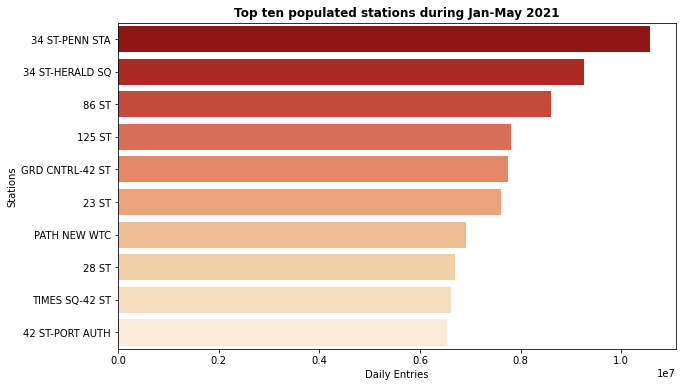

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
bar_one = sns.barplot(data=station_total.head(10),
                      x='DAILY_ENTRIES', y='STATION',
                      palette='OrRd_r').set_title('Top ten populated stations during Jan-May 2021',weight='bold');
ax.set(xlabel = 'Daily Entries')
ax.set(ylabel = 'Stations')
plt.savefig('visuals/station_total.png',dpi=100,bbox_inches='tight')

Things to consider:
- Create some ppt for basic stories.
- Summer time only.
- Eliminate uncessary time components.

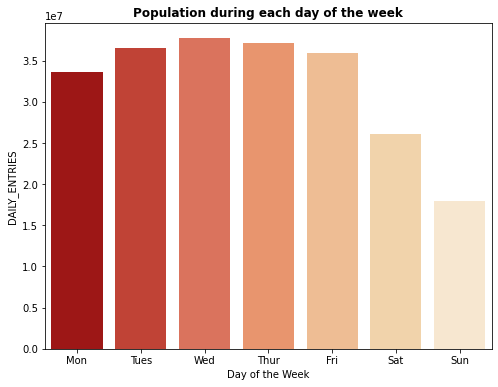

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
bar_two = sns.barplot(data=mta_station_by_day, 
                      x='DAY_NUM', y='DAILY_ENTRIES',
                      palette='OrRd_r').set_title('Population during each day of the week',weight='bold');
ax.set_xticklabels(['Mon','Tues','Wed','Thur','Fri','Sat','Sun']);
ax.set(xlabel = 'Day of the Week')
plt.savefig('visuals/station_by_day.png',dpi=100,bbox_inches='tight')

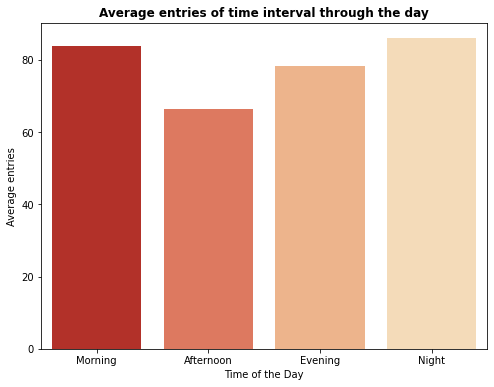

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
bar_three = sns.barplot(data=mta_time_interval, 
                      x='TIME_OF_DAY', y='INTERVAL_ENTRIES',
                      palette='OrRd_r').set_title('Average entries of time interval through the day',weight='bold');
ax.set(xlabel = 'Time of the Day')
ax.set(ylabel = 'Average entries')
plt.savefig('visuals/time_interval_avg.png',dpi=100,bbox_inches='tight')

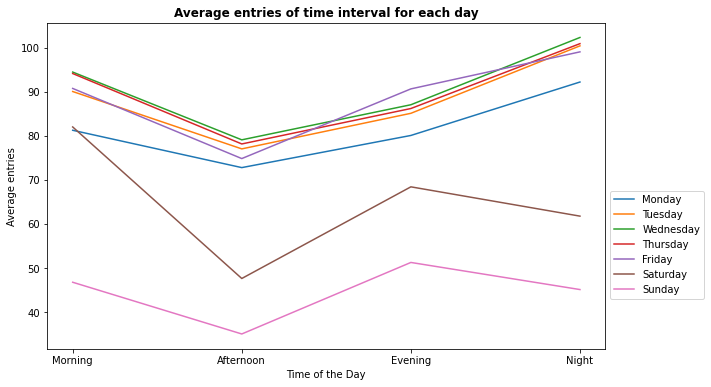

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
line_one = sns.lineplot(x = 'TIME_OF_DAY', y = 'INTERVAL_ENTRIES',
             data=mta_day_time_interval,
             hue='DAY_NUM',
             palette='tab10').set_title('Average entries of time interval for each day',weight='bold');
ax.set(xlabel = 'Time of the Day')
ax.set(ylabel = 'Average entries')
plt.legend(bbox_to_anchor=(1,0.5), loc='upper left',
           labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.savefig('visuals/lineplot.png',dpi=100,bbox_inches='tight')

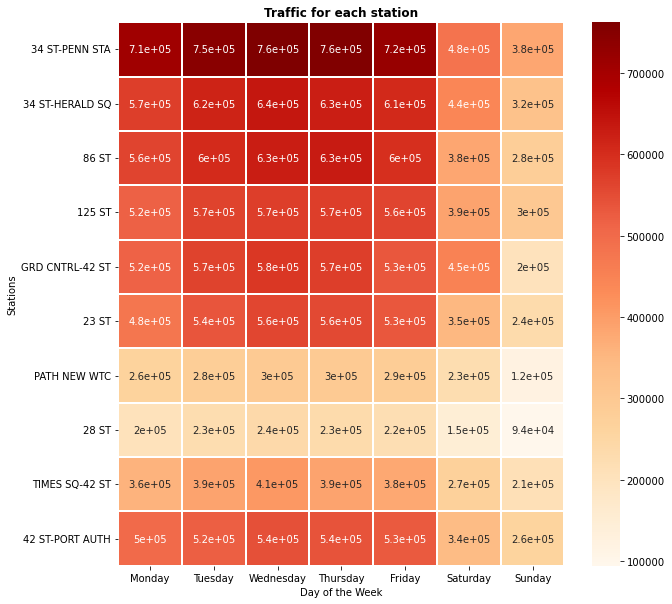

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
heatmap_one = sns.heatmap(data=for_heatmap.T,
                          cmap='OrRd',
                          linecolor='white', annot=True,
                          linewidth=2).set_title('Traffic for each station',weight='bold');
ax.set(xlabel = 'Day of the Week')
ax.set(ylabel = 'Stations')
plt.savefig('visuals/heatmap.png',dpi=100,bbox_inches='tight')